In [390]:
from CSOWP_SR import *
from ExpressionTree import *
from trainAlgorithm import *
import matplotlib.pyplot as plt
import pandas as pd
import graphviz
from re import sub
import numpy as np
from scipy.optimize import curve_fit

plt.rcParams.update({"text.usetex": True})

class Plotter():
    
    def __init__(self, original_func, real_func_string=None, set_seaborn=False):
        self.original_func = original_func
        
        if real_func_string is None:
            self.real_func_string = "Real"
        else:
            self.real_func_string = fr"Real - ${real_func_string}$"
        
        if set_seaborn:
            import seaborn as sns
            sns.set()
            
            
    def getSmpTreeGraph(self, real=False):
    
        if real:
            sexp = self.real_sexp
        else:
            sexp = self.sexp
    
        for i in smp.preorder_traversal(sexp):
            if isinstance(i, smp.Float):
                sexp = sexp.subs(i, round(i, 2))

        s = smp.printing.dot.dotprint(sexp).replace("Add", "+").replace("Mul", "*")
        s = sub('0+(?=")', "0", s)

        if self.img_path is None:
            s = graphviz.Source(s)
        else:
            s = graphviz.Source(s, filename=self.img_path+".gv", format="png")
            s.render()

        return s

    def convert_smp_to_latex(self, sexp, floating_points=2):
        plot_sexp = sexp
        for i in smp.preorder_traversal(plot_sexp):
                if isinstance(i, smp.Float):
                    plot_sexp = plot_sexp.subs(i, round(i, floating_points))
        
        pred_label = smp.latex(plot_sexp)
        pred_label = sub("operatorname", "mathrm", pred_label)
        pred_label = fr"Predicted - ${pred_label}$"
        return pred_label
        
    def fit(self, dir_path, X, y, operators, functions, feature_names, cleaned_data="results.csv"):
        self.dir_path = dir_path
        self.X = X
        self.y = y
        self.operators = operators
        self.functions = functions
        self.feature_names = feature_names
        self.cleaned_data = cleaned_data
        self.title = dir_path[dir_path.find("/")+1:]
        
        #Continue from here
        data = pd.read_csv(dir_path + "/" + cleaned_data)
        self.best_tree = data.sort_values("fitness_score", axis=0)
        self.best_tree = self.best_tree.reset_index(drop=True)

        self.best_population = str(self.best_tree.population[0])
        self.best_generation = str(self.best_tree.generations[0])
        self.best_time = self.best_tree.training_time[0]/60.0
        self.best_fitness = self.best_tree.fitness_score[0]

        self.img_path = self.dir_path + "/trees/tree-" + self.best_population + "-" + self.best_generation

        with open(self.img_path, "rb") as file:
            self.best_tree = pickle.load(file)

        self.func, self.sexp, self.real_sexp = self.best_tree.toFunc(operators, functions, feature_names,  inv_data = {
            "Xmin": self.X.min(),
            "Xmax": self.X.max(),
            "ymin": self.y.min(),
            "ymax": self.y.max()
        })
        
        self.pred_label = self.convert_smp_to_latex(self.sexp)
        

        self.x_range = self.X.max() - self.X.min()
        self.y_range = self.y.max() - self.y.min()
        
    
    
    
    def least_squares(self, y_pred):
        return np.mean( (self.y-y_pred)**2 )


    def plot_pred_graph(self, real=False):
        self.getSmpTreeGraph(real=real)
        
        fig, axs = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [4, 1]})


        ax=axs[0]

        ax.set_title(r"Real Function X Predicted Function - " + f"{self.title}", fontsize=14)
        ax.set_ylabel("y")
        ax.set_xlabel("x")

        ax.plot(self.X, self.y, label=self.real_func_string) 
        ax.plot(self.X, self.func(self.X), label=self.pred_label)
        ax.legend(fontsize=14, loc="upper left")


        ax = axs[1]
        ax.annotate(f"""Training Time: {self.best_time:.2f} minutes
            Normalized Fitness Score: {self.best_fitness:.2E}
            Real Fitness Score: {self.least_squares(self.func(X)):.2E}
            Population Size: {self.best_population}""", 
                (-self.x_range/X.max()/3, ax.get_ylim()[1]-1.7/self.y_range), bbox={"facecolor": "lightgray", "edgecolor": "black"},
                linespacing = 1.5, annotation_clip=False)

        img = plt.imread(self.img_path+".gv.png")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_facecolor((1,1,1))
        ins = ax.inset_axes([-self.x_range/X.max()/5, 0, 0.8, 0.8])
        ins.imshow(img)
        ins.get_xaxis().set_visible(False)
        ins.get_yaxis().set_visible(False)
        ins.set_title(f"Output Expression")
        plt.show()
        
    def plot_expanded_domain(self, x_lim,n_points, y_lim=None):
        X = np.linspace(x_lim[0], x_lim[1], n_points)
        y = self.original_func(X)
        
        if y_lim:
            plt.y_lim(y_lim)
        
        plt.figure(figsize=(12,6))
        plt.title(r"Expanded Domain Comparison - " + f"{self.title}", fontsize=14)
        plt.ylabel("y")
        plt.xlabel("x")


        plt.plot(X, y, label=self.real_func_string) 
        plt.plot(X, self.func(X), label=self.pred_label)
        plt.legend(fontsize=14, loc="upper left")
    
    def least_squares_expression(self, guess=None, max_iter=10000, mode="real", symb="x", functions=None):
        if mode == "real":
            sexp = self.real_sexp
        elif mode == "normalized":
            sexp = self.sexp
        elif mode == "overfitted":
            sexp = self.real_sexp
            if not functions:
                raise TypeError("Must pass parameter functions if chosen overfitted exp")
                
            variables = symb.split(", ")
            
            for i in smp.preorder_traversal(sexp):
                if (str(type(i)) in functions) or str(i) in variables:
                    
                    sexp = sexp.replace(i, np.random.rand()*i + np.random.rand())
        else:
            raise TypeError("Invalid option of exp")

        
    
        count=0
        symbols = [smp.symbols(symb)]
        for i in smp.preorder_traversal(sexp):
            if isinstance(i, smp.Float) or (isinstance(i, smp.Integer) and str(i) != "-1"):
                symbols.append(smp.symbols(f"a_{count}", Real=True))
                sexp = sexp.subs(i, symbols[-1])
                count += 1
                
                
        # Inverse trasnform for real sexp
        if mode == "real":
            sexp = (self.y.max() - self.y.min())*sexp.subs(symbols[0], (symbols[0] - self.X.min())/(self.X.max() - self.X.min()) ) + self.y.min()
    
            
        func = smp.lambdify(symbols, sexp)
        
        if not guess:
            guess = [1 for i in range(len(symbols)-len(symb))]
        
        
        params, covariance = curve_fit(func, self.X, self.y, guess, maxfev=max_iter)
        
        for i in range(len(symb), len(symbols)):
            sexp = sexp.subs(symbols[i], params[i-1])
        
        func = smp.lambdify(symbols[0], sexp)
        
        return func, sexp
    

    def plot_least_squares(self, guess=None, max_iter=10000, exp="real", functions=None, expanded_domain=False, x_lim=None, n_points=None, ylim=None):
        real_least_func, real_least_sexp = self.least_squares_expression(guess, max_iter, mode="real")
        norm_least_func, norm_least_sexp = self.least_squares_expression(guess, max_iter, mode="normalized")
        over_least_func, over_least_sexp = self.least_squares_expression(guess, max_iter, mode="overfitted", functions=functions)
        
        
        if expanded_domain:
            if not x_lim or not n_points:
                raise TypeError("If expanded domain is True, must pass x_lim and n_points")
                
            X = np.linspace(x_lim[0], x_lim[1], n_points)
            y = self.original_func(X)
        else:
            X = self.X
            y = self.y
            
        
        fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(14,12))
        
        if ylim:
            for ax in axs.reshape(-1, ):
                ax.set_ylim(ylim[0], ylim[1])
        
        ax=axs[0,0]
        ax.set_title("Predicted Function")
        ax.plot(X, y, label=self.real_func_string)
        ax.plot(X, self.func(X), label=self.pred_label)
        ax.legend()
        
        
        ax=axs[0,1]
        ax.set_title("Least Squares on Real Function")
        ax.plot(X, y, label=self.real_func_string)
        ax.plot(X, real_least_func(X), label=self.convert_smp_to_latex(real_least_sexp))
        ax.legend()
        
        ax=axs[1,0]
        ax.set_title("Least Squares on Normalized Function")
        ax.plot(X, y, label=self.real_func_string)
        ax.plot(X, norm_least_func(X), label=self.convert_smp_to_latex(norm_least_sexp))
        ax.legend()
        
        ax=axs[1,1]
        ax.set_title("Least Squares on Overfitted Function")
        ax.plot(X, y, label=self.real_func_string)
        ax.plot(X, over_least_func(X), label=self.convert_smp_to_latex(over_least_sexp))
        ax.legend()

In [255]:
from sklearn.preprocessing import MinMaxScaler

def func(x):
    a=10
    b=-0.5
    c=-0.5
    d=2
    return a*np.exp(b*np.exp(c*x + d))

x_range = (0,15)
n_points = 1000
dir_path = "Outputs/Tests_analysis"
const_range=(-10,10)
population=50
generations=3
max_expression_size=3
normalize=True
n_runs=1

X, y, operators, functions = testAlgorithm(func, x_range, n_points, dir_path, population, generations, 
                  max_expression_size, normalize=True, const_range=const_range,
                  ignore_warning=True, overwrite=True, n_runs=n_runs)

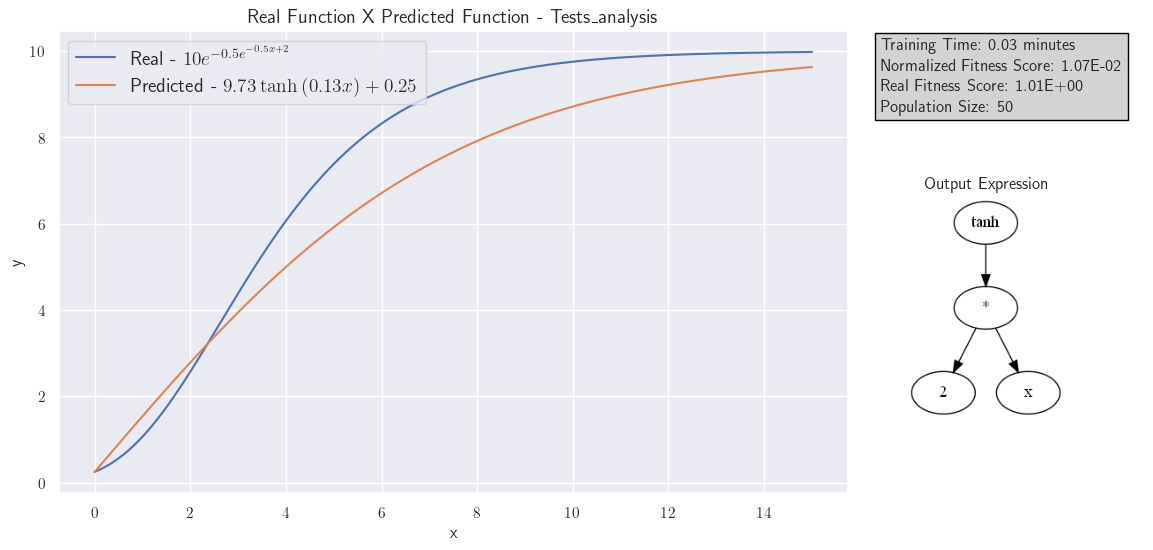

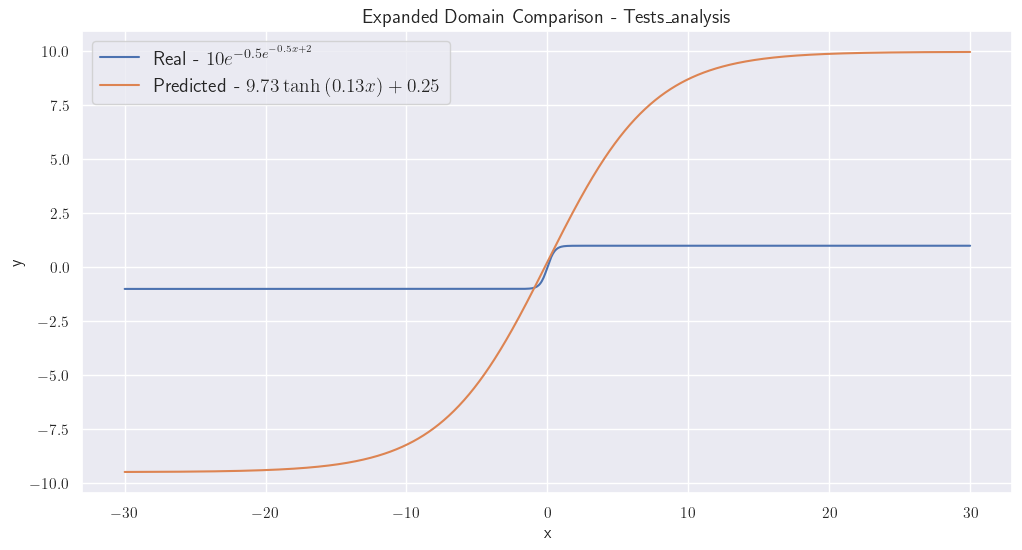

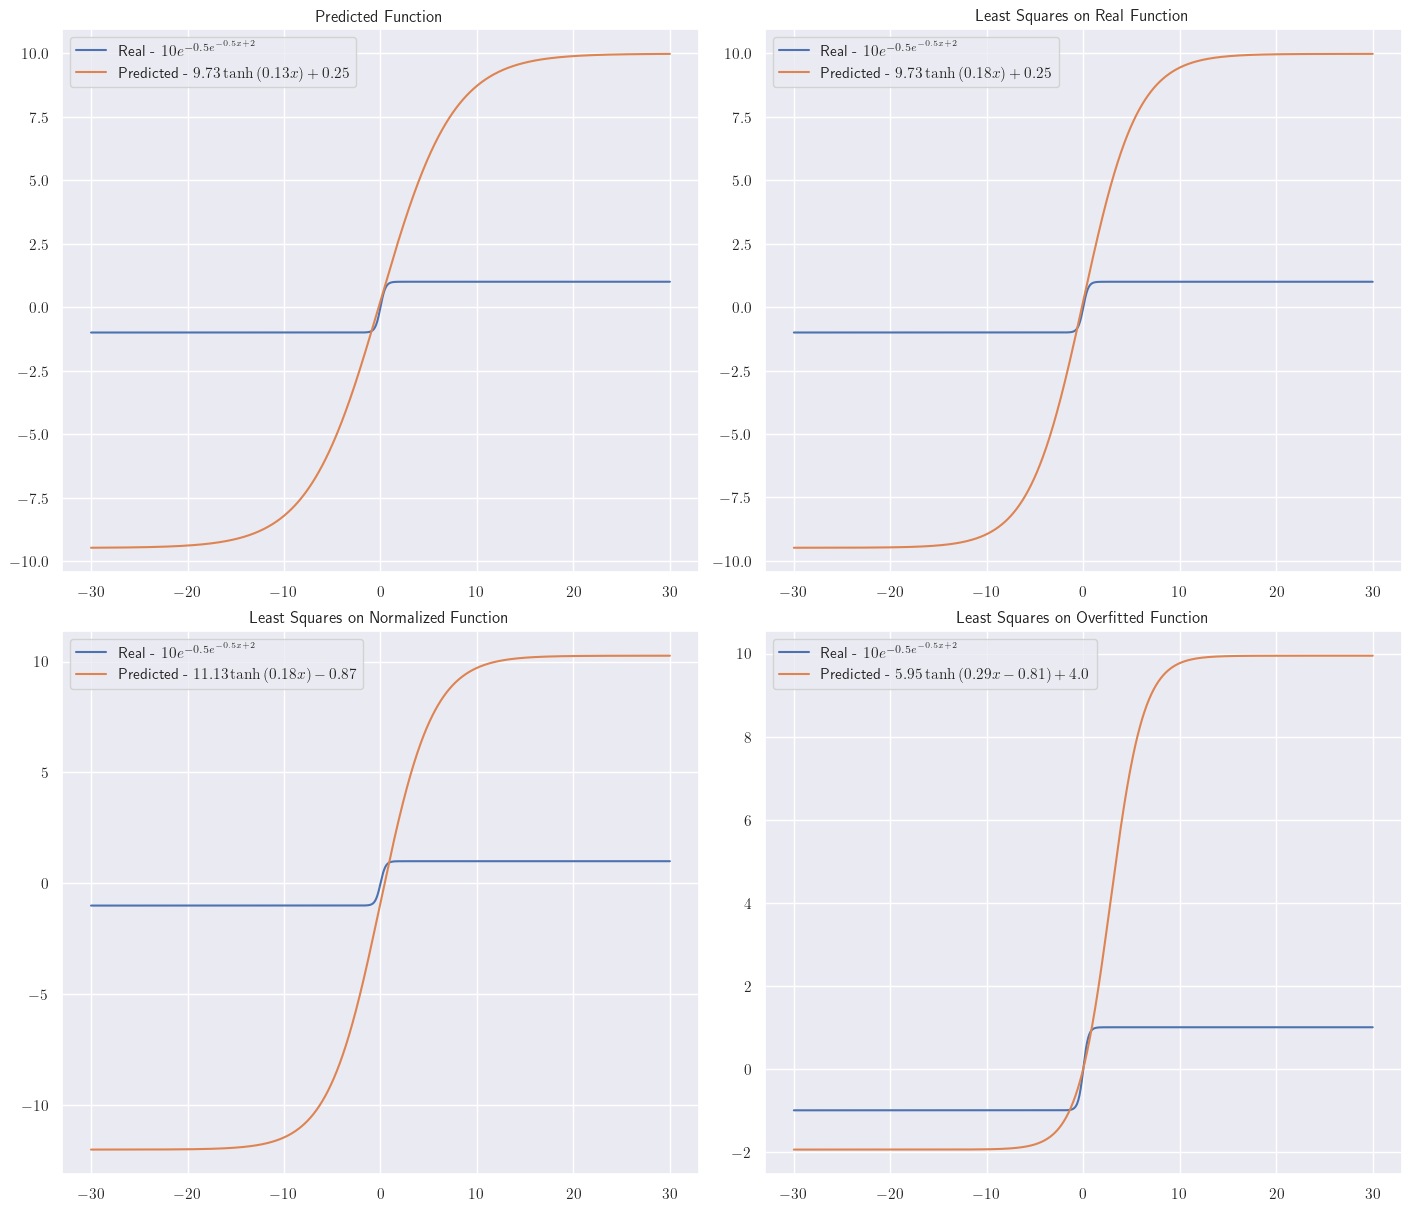

In [392]:
plotter = Plotter(real_func_string = r"10e^{-0.5e^{-0.5x+2}}", set_seaborn=True, original_func=func)
plotter.fit(dir_path, X, y, operators, functions, ["x"])
plotter.plot_pred_graph(real=True)
plotter.plot_expanded_domain([-30, 30], 1000)
plotter.plot_least_squares(functions=functions, expanded_domain=True, x_lim=[-30, 30], n_points=1000)